# Walkthrough notebook for the APPLESOSS (A Producer of ProfiLEs for SOSS) Module
Construct spatial profiles based on a given observed dataset for the first three SOSS orders to be used as the specprofile reference file in the ATOCA algorithm.

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

from applesoss import applesoss
from applesoss.edgetrigger_centroids import get_soss_centroids

### Test the edgetrigger centroiding algorithm

The edgetrigger algorithm locates the centroid of the curved SOSS trace for all three orders as the median between the trace edges. 

In [2]:
# Open a simulated data set, as well as spectrace and 2D wavelength solution reference files.
clear = fits.getdata('applesoss/Ref_files/simulated_data.fits', 0)
spectrace = 'applesoss/Ref_files/jwst_niriss_spectrace_0023.fits'
wavemap = 'applesoss/Ref_files/jwst_niriss_wavemap_0013.fits'

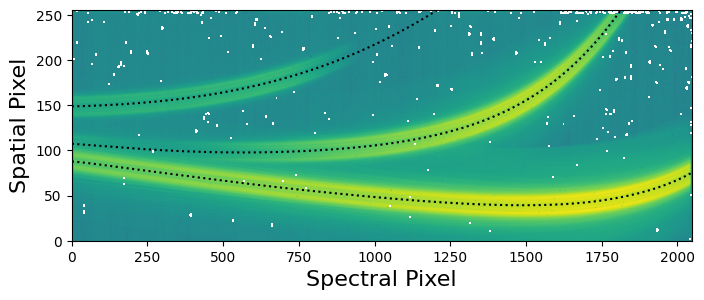

In [3]:


# Get the trace centroids for all three orders.

floor = np.nanpercentile(clear, 0.1)
clear -= floor
cen = get_soss_centroids(clear, spectrace, subarray='SUBSTRIP256')

# Plot the data frames
fig = plt.figure(figsize=(8, 3), facecolor='white')
plt.imshow(np.log10(clear), origin='lower', aspect='auto')
plt.plot(cen['order 1']['X centroid'], cen['order 1']['Y centroid'], ls=':', c='black')
plt.plot(cen['order 2']['X centroid'], cen['order 2']['Y centroid'], ls=':', c='black')
plt.plot(cen['order 3']['X centroid'], cen['order 3']['Y centroid'], ls=':', c='black')

plt.xlabel('Spectral Pixel', fontsize=16)
plt.ylabel('Spatial Pixel', fontsize=16)
plt.ylim(0, 256)
plt.show()

# Add back the floor level
clear += floor

### Build the spatial profiles
The ```EmpiricalProfile``` class of APPLESOSS is the workhorse of this module. To initialize it, it requires a CLEAR exposure data frame, as well as the 2D wavelength solution and spectrace reference files. Optional arguments are the amount of padding to add around the edges of the frames, as well as the factor of oversampling.  

Call ```build_empirical_profile``` once the class is initialized to reconstruct the spatial profiles for the first, second, and third orders. 

Afterwards, the ```write_specprofile_reference``` method can be called to save the profiles to an external file for use as the specprofile reference file needed by the ATOCA algorithm.

In [4]:
clear = fits.getdata('APPLESOSS/Ref_files/simulated_data.fits', 0)
wavemap = 'APPLESOSS/Ref_files/jwst_niriss_wavemap_0013.fits'
spectrace = 'APPLESOSS/Ref_files/jwst_niriss_spectrace_0023.fits'

spat_prof = applesoss.EmpiricalProfile(clear, wavemap, spectrace)
spat_prof.build_empirical_profile(verbose=1, wave_increment=0.1)

Starting the applesoss module.

 Initial processing.
  Interpolating bad pixels...
  Getting trace centroids...
  Generating 23 PSFs... Expected to take about 3 min(s).
 Building the spatial profile models.
  Starting the first order model...
  Starting the second order trace...
  Starting the third order trace...
 Adding padding to the spectral axis...

Done.


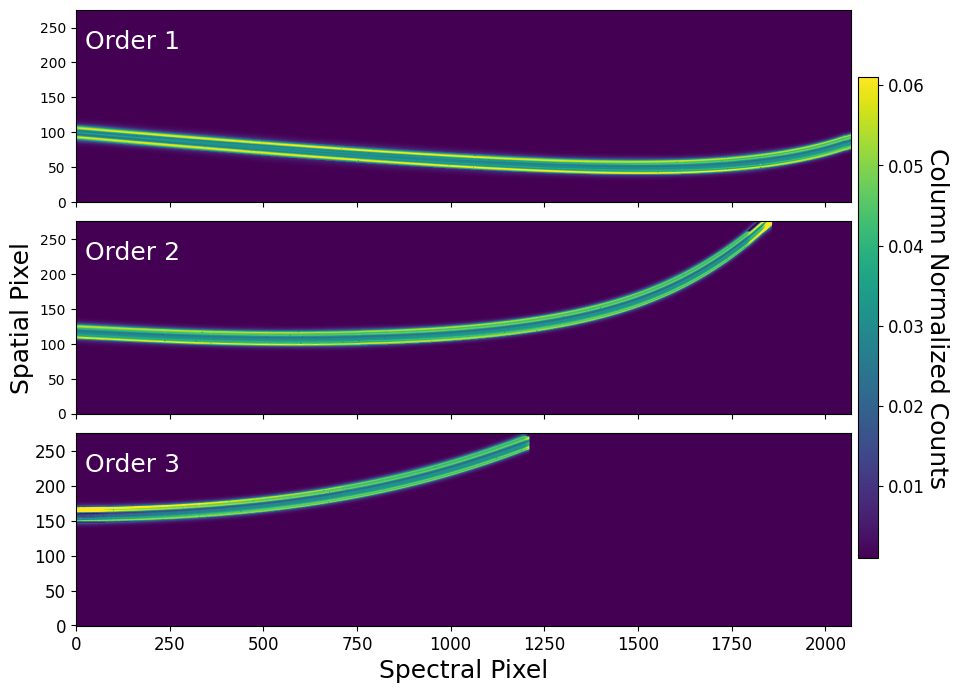

In [5]:
# Show the spatial profile models for each order.
fig, ax = plt.subplots(3, figsize=(10, 8), facecolor='white')

ax1 = ax[0]
ax1.imshow(spat_prof.order1, origin='lower', aspect='auto', vmax=0.061, vmin=0.001)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
plt.yticks(fontsize=12)
ax1.text(25, 220, 'Order 1', fontsize=18, c='white')

ax2 = ax[1]
aa = ax2.imshow(spat_prof.order2, origin='lower', aspect='auto', vmin=0.001, vmax=0.061)
cax = ax2.inset_axes([1.01, -0.75, 0.025, 2.5], transform=ax2.transAxes)
cbar = plt.colorbar(aa, ax=ax[:], cax=cax)
cbar.set_label(r'Column Normalized Counts', rotation=270, fontsize=18, labelpad=18)
cbar.ax.tick_params(labelsize=12)

ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.set_ylabel('Spatial Pixel', fontsize=18)
plt.yticks(fontsize=12)
ax2.text(25, 220, 'Order 2', fontsize=18, c='white')

ax3 = ax[2]
ax3.imshow(spat_prof.order3, origin='lower', aspect='auto', vmin=0.001, vmax=0.061)
ax3.set_xlabel('Spectral Pixel', fontsize=18)
ax3.text(25, 220, 'Order 3', fontsize=18, c='white')

plt.subplots_adjust(hspace=0.1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [31]:
# Create a SUBSTRIP256 spatial profile reference file
spat_prof.write_specprofile_reference('SUBSTRIP256')

Saving to file APPLESOSS_ref_2D_profile_SUBSTRIP256_os1_pad0.fits
